# Gradient descent algorithm for Scenario 2


In this part, we implement an gradient descent algorithm to optimization the objective loss function in Scenario 2:


$$\min F := \min \frac{1}{2(n-i)} \sum_{i=1000}^n (fbpredic(i) + a*tby(i) +b*ffr(i) + c*fta(i) - asp(i))^2$$

Gradient descent: 

$$ \beta_k = \beta_{k-1} + \delta* \nabla F, $$
where $\delta$ control how far does each iteration go.


### Detailed plan

First, split the data as train and test with 80% and 20% respectively. For the training part, we need prophet() predicted price, there are a couple of issues. One is prophet() can not predict too far in the future. The other is we can not call prophet() too many times, this takes a lot of time. So we will use a sliding window strategy:

1, Split the train data as train_1 and train_2, where train_1 is used as a sliding window to fit prophet(), and give predictions in train_2. Train_2 is used train the model we proposed above.

2, After we got full size (size of train_2) predictions from prophet(), then we use gradient descent to fit the above model, extracting the coefficients of features to make predicution in the testing data.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
# processing data, removing the space in coumn names
total_data= pd.read_csv('../data/df4.csv')
new_name = [name.strip() for name in total_data.columns]
total_data.columns = new_name
total_data = total_data.sort_values(by='Date')

#extract features to use
sub_feature = ['Date','Close','tby','ffr','fta','eps','div']
total_data = total_data[sub_feature]


total_data=total_data.iloc[:10000]

#change the columns names for fitting prophet()
total_data.columns = ['ds','y','tby','ffr','fta','eps','div']
 


total_data

,ds,y,tby,ffr,fta,eps,div
0,2003-01-02,909.03,4.07,1.24,732202.0,40.40,1.79
1,2003-01-03,908.59,4.05,1.24,732202.0,40.40,1.79
2,2003-01-06,929.01,4.09,1.24,732202.0,40.40,1.79
3,2003-01-07,922.93,4.04,1.24,732202.0,40.40,1.79
4,2003-01-08,909.93,4.00,1.24,724902.0,40.40,1.79
...,...,...,...,...,...,...,...
4515,2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58
4516,2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58
4517,2021-01-27,3750.77,1.04,0.09,7404926.0,95.72,1.58
4518,2021-01-28,3787.38,1.07,0.09,7404926.0,95.72,1.58


In [4]:
#feature normalization

normal_constants = []

for col in total_data.columns[1:]:
    tmp_max = np.max(abs(total_data[col]))
    normal_constants.append(tmp_max)
    total_data[col]= total_data[col]/tmp_max

print(normal_constants)

print(total_data.head())


[3855.36, 5.26, 5.26, 7414942.0, 143.76, 3.6]
           ds         y       tby       ffr       fta       eps       div
0  2003-01-02  0.235783  0.773764  0.235741  0.098747  0.281024  0.497222
1  2003-01-03  0.235669  0.769962  0.235741  0.098747  0.281024  0.497222
2  2003-01-06  0.240966  0.777567  0.235741  0.098747  0.281024  0.497222
3  2003-01-07  0.239389  0.768061  0.235741  0.098747  0.281024  0.497222
4  2003-01-08  0.236017  0.760456  0.235741  0.097762  0.281024  0.497222


In [5]:
train_size = int(0.9*total_data.shape[0])
train_data = total_data.iloc[:train_size]
test_data= total_data.iloc[train_size:]

print(train_data,test_data)

              ds         y       tby       ffr       fta       eps       div
0     2003-01-02  0.235783  0.773764  0.235741  0.098747  0.281024  0.497222
1     2003-01-03  0.235669  0.769962  0.235741  0.098747  0.281024  0.497222
2     2003-01-06  0.240966  0.777567  0.235741  0.098747  0.281024  0.497222
3     2003-01-07  0.239389  0.768061  0.235741  0.098747  0.281024  0.497222
4     2003-01-08  0.236017  0.760456  0.235741  0.097762  0.281024  0.497222
...          ...       ...       ...       ...       ...       ...       ...
4063  2019-04-03  0.745300  0.479087  0.460076  0.530754  0.974054  0.544444
4064  2019-04-04  0.746854  0.477186  0.460076  0.530754  0.974054  0.544444
4065  2019-04-05  0.750316  0.475285  0.460076  0.530754  0.974054  0.544444
4066  2019-04-08  0.751102  0.479087  0.460076  0.530754  0.974054  0.544444
4067  2019-04-09  0.746545  0.477186  0.460076  0.530754  0.974054  0.544444

[4068 rows x 7 columns]               ds         y       tby       ffr     

 Use prophet() to make predictions, we will split training as train_1 and train_2 with ratio 40% vs 60%, 
 train_1 will be used to fit prophet(), then predict on train_2.  Getting the predictions, feed the data into
 the Scenario 2 model, train again to get the parameters a,b,c,....

In [21]:
#prophet part 
import fbprophet as prophet
window_size = 1000
pred_size =100
num_winds = 35


train_2 = train_data.iloc[window_size:]

pro_pred = []


for i in range(num_winds):
    
    tmp_train = train_data.iloc[i*pred_size:i*pred_size+window_size].copy()
    
    my_prophet = prophet.Prophet(daily_seasonality=True, yearly_seasonality=True)
    my_prophet.fit(tmp_train[['ds','y']])
    my_test_dates = my_prophet.make_future_dataframe(periods = pred_size)
    tmp_forecast = my_prophet.predict(my_test_dates)
    pro_pred.append(tmp_forecast.yhat[-100:]) #-100 correspond to pred_size =100

In [37]:
#flatten the pro_pred 
flat_pro_pred = [item for l1 in pro_pred for item in l1]

#Next, we will fit our own model on the 5000 data set, then predict on the testing_data

sc2_X = train_data[['tby','ffr','fta','eps','div']].copy()
sc2_XX = sc2_X.iloc[568:]

sc2_y = train_data.y.copy()
sc2_yy = sc2_y.iloc[568:] - flat_pro_pred


In [38]:
sc2_XX

,tby,ffr,fta,eps,div
568,0.832700,0.530418,0.107633,0.574012,0.469444
569,0.832700,0.530418,0.108799,0.574012,0.469444
570,0.830798,0.530418,0.108799,0.574012,0.469444
571,0.811787,0.530418,0.108799,0.574012,0.469444
572,0.811787,0.530418,0.108799,0.574012,0.469444
...,...,...,...,...,...
4063,0.479087,0.460076,0.530754,0.974054,0.544444
4064,0.477186,0.460076,0.530754,0.974054,0.544444
4065,0.475285,0.460076,0.530754,0.974054,0.544444
4066,0.479087,0.460076,0.530754,0.974054,0.544444


In [39]:
# gradient descent algorithm 
def grad_descent(X,y,itr,delta):
    n,m = X.shape
    tol =10**-9
    
    
    #initialization 
    beta_old = np.zeros(m)
    beta_new = np.zeros(m)
    
    #grad = np.zeros(m)
    
    totl_itrs = itr
    
    for i in range(itr):
        beta_new = beta_old - (delta/n)*X.transpose().dot(np.subtract(X.dot(beta_old),y))
        
        
        
        
        #grad = (y-X.dot(beta[i,])).dot(-X)/n
        
        #beta[i+1,] = beta[i,] + delta*grad
        error = np.sum((beta_new-beta_old)**2)
        
        if  error <tol:
            return beta_new
            
        beta_old = beta_new
           
    
    

In [40]:
#get the coefficents output from grad_descent algorithm
coef_abc = grad_descent(sc2_XX.values,sc2_yy.values,10000,0.2)


new_sc2_yy = sc2_XX.values.dot(coef_abc)

#compute fitted value on train_2 and scale it back 
fitting_train  = normal_constants[0]*(new_sc2_yy + flat_pro_pred)




In [41]:
print(coef_abc)

[ 0.13154874  0.04273502 -0.04600443 -0.01498159 -0.18533107]


Text(0.5, 1.0, 'Fitting on the training data')

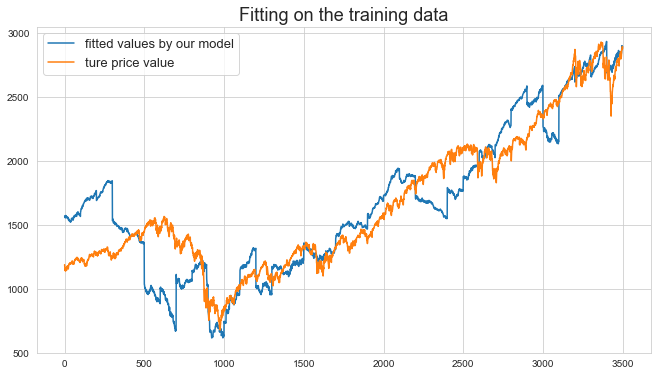

In [44]:
plt.figure(figsize=(11,6))
plt.plot(range(0,3500),fitting_train,label="fitted values by our model")
plt.plot(range(0,3500),sc2_y.iloc[568:]*normal_constants[0],label='ture price value')

plt.legend(fontsize=13)

plt.title("Fitting on the training data",fontsize=18)

In [48]:
# we make predictions on the tesing data using our fitted model 

#get fb prophet() first 

test_proph = prophet.Prophet()
test_proph.fit(train_data[['ds','y']].iloc[-4000:].copy())
test_proph_dates = test_proph.make_future_dataframe(periods = pred_size)
test_pred_proph = test_proph.predict(test_proph_dates)



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [50]:


#get other features prediction
test_sc2_XX = test_data[['tby','ffr','fta','eps','div']].copy()

testpred_abc_feature = test_sc2_XX.dot(coef_abc)



#final prediction 
test_total_pred = normal_constants[0]*(testpred_abc_feature.values + test_pred_proph.yhat[-452:].values)

test_sc2_XX

,tby,ffr,fta,eps,div
4068,0.471483,0.460076,0.530926,0.974054,0.544444
4069,0.477186,0.460076,0.530926,0.974054,0.544444
4070,0.486692,0.460076,0.530926,0.974054,0.544444
4071,0.484791,0.460076,0.530926,0.974054,0.544444
4072,0.494297,0.460076,0.530926,0.974054,0.544444
...,...,...,...,...,...
4515,0.199620,0.017110,1.000000,0.665832,0.438889
4516,0.199620,0.017110,1.000000,0.665832,0.438889
4517,0.197719,0.017110,0.998649,0.665832,0.438889
4518,0.203422,0.017110,0.998649,0.665832,0.438889


In [51]:
#test_pred_proph.yhat[-1000:].values
print(coef_abc)
sc2_XX


[ 0.13154874  0.04273502 -0.04600443 -0.01498159 -0.18533107]


,tby,ffr,fta,eps,div
568,0.832700,0.530418,0.107633,0.574012,0.469444
569,0.832700,0.530418,0.108799,0.574012,0.469444
570,0.830798,0.530418,0.108799,0.574012,0.469444
571,0.811787,0.530418,0.108799,0.574012,0.469444
572,0.811787,0.530418,0.108799,0.574012,0.469444
...,...,...,...,...,...
4063,0.479087,0.460076,0.530754,0.974054,0.544444
4064,0.477186,0.460076,0.530754,0.974054,0.544444
4065,0.475285,0.460076,0.530754,0.974054,0.544444
4066,0.479087,0.460076,0.530754,0.974054,0.544444


Text(0.5, 1.0, 'Prediction on the testing data')

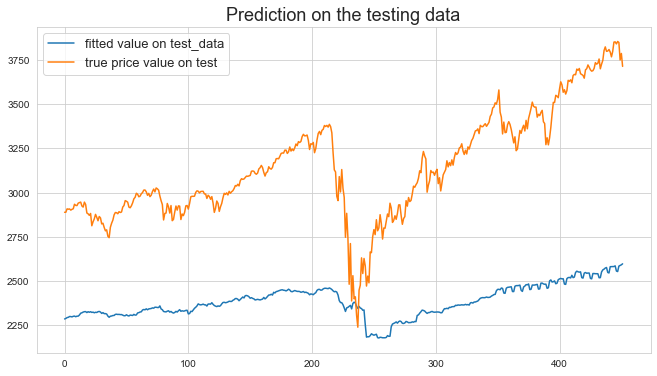

In [53]:
plt.figure(figsize=(11,6))
plt.plot(range(0,452),test_total_pred,label='fitted value on test_data')
plt.plot(range(0,452),test_data['y']*normal_constants[0],label='true price value on test')

plt.legend(fontsize=13)
plt.title("Prediction on the testing data",fontsize=18)